In [1]:
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_and_preprocess_image(path):
    #load img
    image = tf.io.read_file(path)
    #preprocess
    image = tf.cond(
        tf.image.is_jpeg(image),
        lambda: tf.image.decode_jpeg(image, channels=3),
        lambda: tf.image.decode_png(image, channels=3))
    #image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (64, 64))
    image = (image - 127.5) / 127.5  # [-1, 1]
    
    return image

In [3]:
def load_normalized_dataset(path):
    image_samples_path = list()
    class_count = 1
    for class_dir in os.listdir(path):
        img_sample_count = 1
        full_class_dir = os.path.join(path, class_dir)
        for image_name in os.listdir(full_class_dir):
            full_image_name = os.path.join(full_class_dir, image_name)
            image_samples_path.append(full_image_name)
            img_sample_count += 1
        class_count += 1

    random.shuffle(image_samples_path)
    scene_dataset = tf.data.Dataset.from_tensor_slices(image_samples_path)
    scene_dataset = scene_dataset.map(load_and_preprocess_image)
    batch_size = 2
    scene_dataset = scene_dataset.batch(batch_size)

    return scene_dataset

In [4]:
scene_dataset = load_normalized_dataset("../data/Pikachu/New folder")
print(list(scene_dataset.as_numpy_iterator()))
scene_dataset

[array([[[[0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         ...,
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686]],

        [[0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         ...,
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686]],

        [[0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         ...,
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686]],

        ...,

        [[0.99215686, 0.99215686, 0.99215686],
         [0.99215686, 0.99215686, 0.99215686

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [23]:
def generator():
    model = keras.Sequential([
        layers.Dense(units=8 * 8 * 2, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 2)),

        layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),

        layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),

        layers.Conv2DTranspose(filters=256, kernel_size=(3,3), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),

        layers.Conv2DTranspose(filters=3, kernel_size=(3,3), strides=(2,2), padding="same", use_bias=False,
                               activation="tanh"),
    ])
    return model

In [24]:
gen_model = generator()
gen_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               12800     
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128)               0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 2)           0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 8, 8, 64)          1152      
 Transpose)                                                      
                                                                 
 batch_normalization_5 (Bat  (None, 8, 8, 64)         

In [25]:
def generator_loss(fake_output):
    cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
def generator_optimizer():
    return tf.optimizers.Adam(1e-4)

In [27]:
gen_optimizer = generator_optimizer()

In [28]:
def discriminator():
    model = keras.Sequential([
        layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same',
                      input_shape=[64, 64, 3]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(rate=0.3),
        
        layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(rate=0.3),

        layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(rate=0.3),

        layers.Flatten(),
        layers.Dense(units=1)
    ])
    return model

In [29]:
dis_model = discriminator()
dis_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 256)        

In [30]:
def discriminator_loss(real_output,
                       fake_output):
    cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [31]:
def discriminator_optimizer():
    return tf.optimizers.Adam(1e-4)

In [32]:
dis_optimizer = discriminator_optimizer()

In [33]:
def train_step(images, gen_model, gen_optimizer, dis_model, dis_optimizer, gen_loss_metric, dis_loss_metric):
    noise = tf.random.normal([9, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen_model(noise, training=True)

        real_output = dis_model(images, training=True)
        fake_output = dis_model(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, gen_model.trainable_variables))
    dis_optimizer.apply_gradients(zip(gradients_of_discriminator, dis_model.trainable_variables))

    gen_loss_metric(gen_loss)
    dis_loss_metric(disc_loss)



In [34]:
def test_step(real_images, gen_model, dis_model):
    random_seed = tf.random.normal([9, 100])
    fake_images = gen_model(random_seed, training=False)

    real_dis_prediction = dis_model(real_images)
    fake_dis_prediction = dis_model(fake_images)

    correct = len(real_dis_prediction[real_dis_prediction >= 0.0])
    wrong = len(real_dis_prediction[real_dis_prediction < 0.0])
    real_dis_acc = float(correct) / float(correct + wrong)

    correct = len(fake_dis_prediction[fake_dis_prediction < 0.0])
    wrong = len(fake_dis_prediction[fake_dis_prediction >= 0.0])
    fake_dis_acc = float(correct) / float(correct + wrong)

    combined_dis_acc = (real_dis_acc + fake_dis_acc) / 2

    return real_dis_acc, fake_dis_acc, combined_dis_acc

In [35]:
def loss_and_accuracy(gen_loss_metric, epoch, dis_loss_metric, real_dis_acc, fake_dis_acc, combined_dis_acc):
    print('Loss')
    print('Generator:{}'.format(gen_loss_metric.result()))
    print('Discriminator:{}'.format(dis_loss_metric.result()))
    print('Accuracy')
    print('Real Discriminator:{}'.format(real_dis_acc))
    print('Fake Discriminator:{}'.format(fake_dis_acc))
    print('Combined Discriminator:{}'.format(combined_dis_acc))
    gen_loss_metric.reset_states()
    dis_loss_metric.reset_states()

In [36]:
def weights_and_biases(gen_model, epoch, dis_model):
    print('Generator Weights')
    for gen_layer in gen_model.layers:
        print(gen_layer.name + ':{}'.format(gen_layer.get_weights()[0]))
        print('Discriminator')
        for dis_layer in dis_model.layers:
            print('Weights')
            print(dis_layer.name + ':{}'.format(dis_layer.get_weights()[0]))
            print('Biases')
            print(dis_layer.name + ':{}'.format(dis_layer.get_weights()[1]))

In [37]:
def generate_and_save_images(model, epoch):
    test_input = tf.random.normal([9, 100])
    predictions = gen_model(test_input, training=False)
    fig = plt.figure(figsize=(3, 3))
    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        img = np.array(predictions[i]) * 127.5 + 127.5
        img = img.astype(np.uint8, copy=False)
        plt.imshow(img)
        plt.axis('off')
    plt.savefig('../res/gif5/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [38]:
def save_image(gen_model, epoch):
    test_input = tf.random.normal([9, 100])
    predictions = None
  #  if (epoch % 1000 == 0):
    predictions = gen_model(test_input, training=False)

   # if epoch % 1000 == 0:
    for i in range(predictions.shape[0]):
        img = np.array(predictions[i]) * 127.5 + 127.5
        img = img.astype(np.uint8, copy=False)
        plt.imsave('../res/gif5/image_at_epoch_{:05d}_{:05d}.png'.format(epoch, i), img)


In [39]:
def train(real_image_dataset,  epochs, gen_model, gen_optimizer, dis_model, dis_optimizer):
    gen_loss_metric = keras.metrics.Mean('train_loss', dtype=tf.float32)
    dis_loss_metric = keras.metrics.Mean('train_loss', dtype=tf.float32)
    for epoch in range(epochs):
        print('Epoch {}'.format(epoch))
        for image_batch in real_image_dataset:
            train_step(image_batch, gen_model, gen_optimizer, dis_model, dis_optimizer, gen_loss_metric, dis_loss_metric)
            real_dis_acc, fake_dis_acc, combined_dis_acc = test_step(image_batch, gen_model, dis_model)
            loss_and_accuracy(gen_loss_metric, epoch, dis_loss_metric, real_dis_acc, fake_dis_acc, combined_dis_acc)
        generate_and_save_images(gen_model, epoch + 1)
        #save_image(gen_model, epoch + 1)

In [ ]:
train(real_image_dataset=scene_dataset,epochs=100000,gen_model=gen_model, gen_optimizer=gen_optimizer, dis_model=dis_model,
            dis_optimizer=dis_optimizer)

In [42]:
import imageio
import glob
import PIL
def display_image(epoch_no):
  return PIL.Image.open('../res/gif5/image_at_epoch_{:04d}.png'.format(epoch_no))

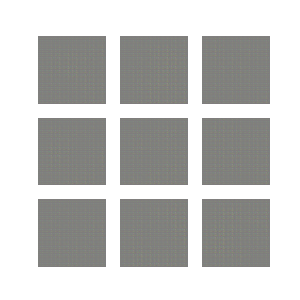

In [43]:
display_image(2)

In [44]:
anim_file = '../res/gif5/gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('../res/gif5/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.v2.imread(filename)
    writer.append_data(image)
  image = imageio.v2.imread(filename)
  writer.append_data(image)

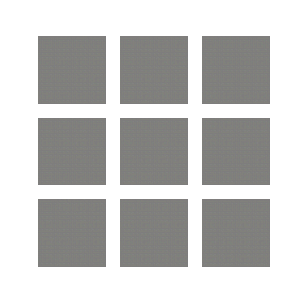

In [45]:
from PIL import Image
im = Image.open('../res/gif5/gan.gif')
im